In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack.realtransforms import dct,idct
import scipy.sparse

# Theory

## Data assimilation

We seek a maximum a posteriori probability (MAP) estimate of a state variable $x$, defined on a spatial grid with $n_r,n_c$ rows and columns and $n_p$ parameters, and grid spacing $\delta r$ which we assume to be the same in row and column direction. Let $n = n_r \times n_c$ and $n_x = n \times n_p$. We assume uncertainty terms throughout the problem are Gaussian. Specifically, we wish to estimate the MAP estimate of mean $x$ and standard variance/covariance matrix $C_x$, given some prior estimate of state and some informative but indirect observations. 

Although we can think of $x$ as a 3D gridded dataset (over rows, columns and parameters), we will mostly refer to it in column form in the following equations, giving $x$ as a vector of length $(n_x)$ to be able to consider correlations. $C_x$ can be rather large, being a matrix of $(n_x, n_x)$. It has entries $(i,j)$:  $C_x^{i,j} = \mathcal{E} \left( (x_i - \bar{x_i})(x_j - \bar{x_j}) \right)$ with $\mathcal{E}$ the expected value operator. We distinguish $\bar{x_i}$ and $\bar{x_j}$ in the covariance as $i$ and $j$ may refer to different properties and $\bar{x_i} = \mathcal{E} \left( x_i \right)$ over all samples in $x$ with the same property as $x_i$. The terms $\bar{x_i}$ form the mean vector $x$. As is usual, we will try to avoid explicitly stating the large matrix $C_x$ and instead provide methods for its application.

Suppose we have observations $y$ of the system on the same grid as $x$, at $n_b$ wavebands  and that we map from state space to observation space through a linear observation operator $H$. A mask $m$ defines where observations are present with a value of $1$ and absent by $0$. We express $y$ in column form as a vector of length $(n_b \times n_x)$, then:

$$
y  = Hx +  \varepsilon_y 
$$

with $\varepsilon_y$ noise from the model and observations that have variance/covariance matrix $C_y$. Here, $H$ a sparse (block-diagonal) matrix of size $(n_b \times n_x,n_x)$. Entries in the diagonals are zero for entries corresponding to pixels with mask $m$ value 0.

As is typical in data assimilation applications (Lewis et al., 2012), we apply sets of constraint to the problem:

* observations $y$ as described above.
* $a\ priori$ estimates of $x$, $x_p$ with associated standard deviation $\sigma_p$ and correlation scale length $h$.

### Covariance matrix structure

In a large problem of this nature, we need to make sure that we can efficiently calculate and store the information we need. This means that where possible, we use sparse matrix representations. We can conveniently use a sparse representation of a correlation function with a low-order autoregressive (AR) model, and we base our choice on the typical first-order AR(1) model which is a discrete-space Markov process over rows and columns of $x$ (after Rogers, 2000). This can be expressed using a first order difference matrix $D$ that we define here for $x$ but which generalises to other quantities:

$$
\delta_{x_{r|c}} = \frac{1}{\delta r} D_{r|c} x
$$

which gives the *spatial* change in $x$ over row or column direction, $\delta_{x_{r|c}}$ over each parameter. Each of the matrices $D_r$ and $D_c$ is large, $(n_x,n_x)$, but banded, and so very sparse. They have block structures to isolate the differences to target parameters in $x$. 

We choose to define $D_{r|c}$ as a forward difference with reflexive boundary conditions because the eigenvectors of this case are conveniently defined by the Discrete Cosine Transformation type II (DCT-II) (Hansen et al., 2006).  Rogers (2000) notes (answer to exercise 10.2, but Rogers misses the required $\frac{\delta r}{2h}$ scaling factor on $I_{n_x}$) that, other than the two end elements of the diagonal, covariance function can be given as: 

$$
C_x^{-1} = \frac{1}{\sigma_x^{2}} \left(  \frac{\delta r}{2h} I_{n_x} + s D_2 \right)
$$



with $s = \alpha/{(1-\alpha)^2}$. Here, the squared differential matrix $D_2 = D^T_r D_r + D^T_c D_c$. $I_{n_x}$ is an identity matrix the same size as $D_2$, and $s$ a smoothing parameter. The corresponding covariance matrix $C_x$ has entries $(i,j)$:  

$$
C_x^{i,j} = \sigma_x^{2} \alpha^{|i-j|}
$$

for $i,j$ samples in the same parameter, with $\alpha = \exp \left( - \delta r / h\right)$.




In [2]:
# form D for 1D for reflexive boundary conditions
# and print the matrix

dr = 0.5 # pixels
h = 15.0 # pixels
nx = int((h/dr) * 12)
sigma_x = 0.015

# derived terms
alpha = np.exp(-dr / h)
s = alpha/((1-alpha*alpha))
print(f'alpha = {alpha:.2f}')
print(f's = {s:.2f}\n')

D = scipy.sparse.diags((np.ones(nx),-np.ones(nx)),\
                       offsets=(0,1)).tolil()
D[-1,:] = 0

Inx = np.eye(nx)
#D[-1,-1] = 0
print(D.todense())

alpha = 0.97
s = 15.00

[[ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]]


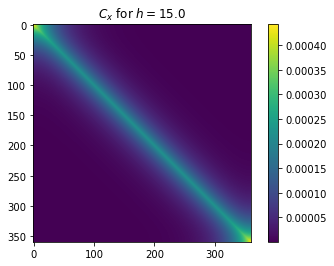

In [3]:
# square the matrix and form Cx1
D2 = np.dot(D.T,D)
Cx1 = np.matrix((1/(sigma_x*sigma_x)) * (Inx*dr/(2.*h) +  s *  D2 ))
# invert to get Cx from D matrices
Cx = np.array(Cx1.I)

plt.figure()
plt.imshow(Cx)
plt.colorbar()
_=plt.title(f'$C_x$ for $h={h}$')


We see, away from the edges, that the covariance has a value of 
sigma_x^2 (=0.000225 here) along the leading diagonal, and 
decays to exp(-1) (=0.000083) 
at +/-h/dr (= +/-30.000000 here).

Close to the edge (within ~4h) the reflexive 
boundary conditions impact the correlation function.



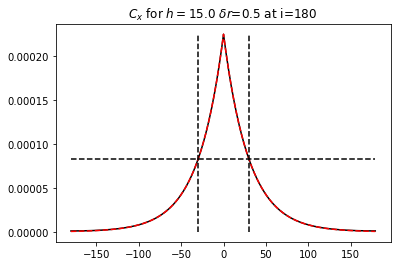

In [4]:
# synthesise Cx as Cx_ from direct equation
i = int(nx/2)

# synthesise
r = np.arange(nx) - i
Cx_ = (sigma_x * sigma_x)*(alpha**np.abs(r))
plt.plot(r,Cx[i],'k')
plt.plot(r,Cx_,'r--')
plt.plot([int(-h/dr),int(-h/dr)],[0,sigma_x**2],'k--')
plt.plot([int(h/dr),int(h/dr)],[0,sigma_x**2],'k--')
plt.plot(r,r*0+sigma_x**2 * np.exp(-1),'k--')

_=plt.title(f'$C_x$ for $h={h}$ $\delta r$={dr} at i={int(nx/2)}')

msg = f'''
We see, away from the edges, that the covariance has a value of 
sigma_x^2 (={(sigma_x**2):.6f} here) along the leading diagonal, and 
decays to exp(-1) (={sigma_x**2 * np.exp(-1):.6f}) 
at +/-h/dr (= +/-{h/dr:.6f} here).

Close to the edge (within ~4h) the reflexive 
boundary conditions impact the correlation function.
'''
print(msg)

### Frequency domain expression

The eigenvectors of $D_2$ are given by the Discrete Cosine Transform type II (DCT-II) (Hansen et al., 2006). Writing $D_2 = U \Lambda^2 U^{−1}$ where $U$ is a forward DCT matrix, $U^{-1}$ the inverse and $\Lambda = diag(\lambda_1,...,\lambda_n)$ with $\lambda_i =(2-2\cos\theta_i)^{p/2}$ with $\theta_i=(i−1)\pi/n$ and $p$ the order of the filter (p=1 here, for a first difference constraint). Here, $\lambda_i$ are the square root of the eigenvalues of $D_2$.  $U$ is a unitary matrix, so $U^{-1} = U^T$. 

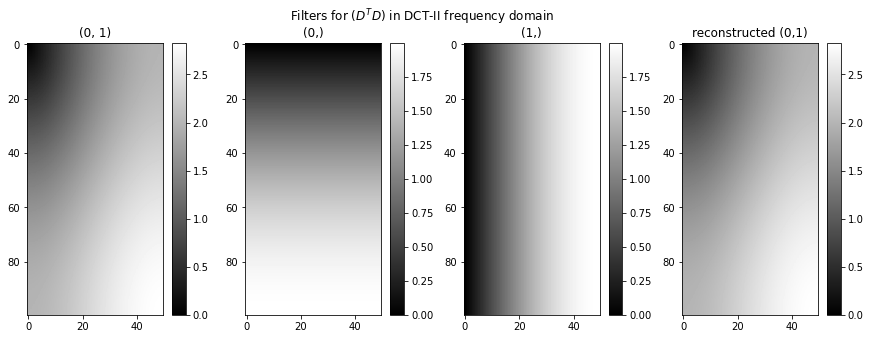

In [5]:
def diffFilter(yshape,order=1,axis=(0,1)):
    '''
    Sqrt DCT-II filter for D2 == D^T D
    
    Returns eigenvalues for order p filter. NB
    Square it when using to obtain the correct filter.
    '''
    ndim = len(yshape)
    Lambda = np.zeros(yshape).astype(float)

    for c,i in enumerate(axis):
        # create a 1 x d array (so e.g. [1,1] for a 2D case
        siz0 = np.ones((1,ndim)).astype(int)[0]
        siz0[i] = yshape[i]
        omega = np.pi*np.arange(yshape[i])/float(yshape[i])
        this = np.cos(omega).reshape(siz0)
        Lambda = Lambda + this
    Lambda = -(len(axis)-Lambda)
    return np.abs((2*Lambda))**(order/2.)

# dataset
shape = (100,50)
# demonstrate creation of filter in 1D and 2D
# testing with nr != nc 

# test for different versions 
# of the filter 
im = np.arange(4,dtype=np.object)
filt = np.arange(4,dtype=np.object)

fig, axs = plt.subplots(1,4,figsize=(15,5))
fig.suptitle('Filters for $(D^TD)$ in DCT-II frequency domain')

for i,axis in enumerate([(0,1),(0,),(1,)]):
    filt[i] = diffFilter(shape,axis=axis)
    im[i] = axs[i].imshow(filt[i],cmap='gray')
    axs[i].set_title(str(axis))
    fig.colorbar(im[i], ax=axs[i], orientation='vertical')

# show that the isotropic filter is the ^2 sum of the
# directional terms (NB these are sqrt filters)
filt[3] = np.sqrt(filt[1]**2 + filt[2]**2)
i = 3
im[i] = axs[i].imshow(filt[i],cmap='gray')
axs[i].set_title('reconstructed (0,1)')
_=fig.colorbar(im[i], ax=axs[i], orientation='vertical')

From above:

$$
C_x^{-1} = \frac{1}{\sigma_x^{2}} \left(  \frac{\delta r}{2h} I_{n_x} + s U \Lambda^2 U^T \right)
$$




so

$$
C_x = \sigma_x^{2} U^T  \Gamma U
$$

with:

$$
\Gamma = \left(  \frac{\delta r}{2h} I_{n_x} + s \Lambda^2 \right)^{-1} 
$$



The matrix $\Gamma$ is diagonal (Garcia, 2010), with elements all zero other than the leading diagonal which is defined by:

$$
\Gamma_{i,i} \equiv \gamma_i = \frac{2h}{\delta r+ 2 h s \lambda_i^2}
$$. 


for $i \in [1,n_x]$, with:

$$
\lambda_i = -2 + 2 \cos \left(\frac{\pi (i-1)}{n_x} \right)
$$

In [6]:
# define DTC utilities

def dctND(data,f=dct):
    for i in np.arange(2):
        data = f(data,norm='ortho',type=2,axis=i)
    return data

def filt(y,dctFilter,thresh=1e-10,do_dct=True):
    '''
    filter y by dctFilter
    with dctFilter in DCT space
    
    if ,do_dct=False, then y is already in dct space
    ''' 
    shape = dctFilter.shape
    if do_dct:
        dcty = dctND(y.reshape(shape),f=dct)
    else:
        y = dcty
    DTDy = dctND(dctFilter * dcty,f=idct)
    DTDy[np.logical_and(DTDy>=-thresh,DTDy<=thresh)] = 0.
    return DTDy


Note how the filter suppresses low frequencies
and passes high frequency



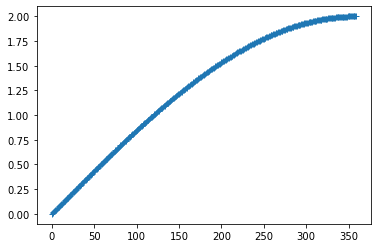

In [7]:
# Test in 1D
i = int(nx/2)
lambda_i = diffFilter((nx,nx),axis=(0,))
plt.plot(lambda_i[:,i],'+')
msg = f'''
Note how the filter suppresses low frequencies
and passes high frequency
'''
print(msg)


Note how the inverse filter passes mainly the low frequencies
with magnitude 2h/dr = 60.00 = 60.00
and at high frequencies have 0.0167
which is h/(dr+4hs) = 0.0167



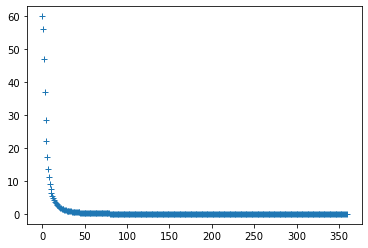

In [8]:
gamma_i = 2*h/(dr + 2 * h * s * lambda_i * lambda_i)
plt.plot(gamma_i[:,i],'+')
msg = f'''
Note how the inverse filter passes mainly the low frequencies
with magnitude 2h/dr = {2*h/dr:.2f} = {gamma_i[0,i]:.2f}
and at high frequencies have {gamma_i[-1,i]:.4f}
which is h/(dr+4hs) = {h/(dr+4*h*s):.4f}
'''
print(msg)

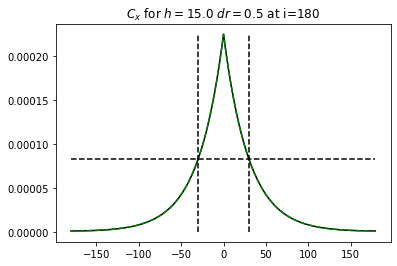

In [9]:
# demonstrate the Frequency domain filter 
# is the same as the others
shape = (nx,nx)
I = np.eye(nx)
F = (sigma_x * sigma_x)*filt(I,gamma_i)

plt.plot(r,Cx[i],'k')
#plt.plot(r,Cx_,'r--')
plt.plot(r,F[i],'g--')

plt.plot([int(-h/dr),int(-h/dr)],[0,sigma_x**2],'k--')
plt.plot([int(h/dr),int(h/dr)],[0,sigma_x**2],'k--')
plt.plot(r,r*0+sigma_x**2 * np.exp(-1),'k--')

_=plt.title(f'$C_x$ for $h={h}$ $dr={dr}$ at i={int(nx/2)}')

## Summary

We have shown that a covariance function defined as a AR(1)/Markov process with given scale length $h$, grid spacing $\delta r$  and variance $\sigma_x^2$ can be described by:

$$
\alpha = \exp \left( - \delta r / h\right)
$$

$$
s = \frac{\alpha}{1- \alpha^2}
$$

* the inverse of a sparse matrix representation using first-order difference matrices:

$$
C_x = \sigma_x^{2} \left(  \frac{\delta r}{2h} I_{n_x} + s D_2 \right)^{-1}
$$


* an analytical function:


$$
C_x^{i,j} = \sigma_x^{2} \alpha^{|i-j|}
$$

for $i,j$ samples in the same parameter.


* a (DCT-II) frequency domain expression:

$$
C_x = \sigma_x^{2} U^T  \Gamma U
$$

with $U$ the DCT-II matrix/transform, $U^T$ its transpose/inverse, and  $\Gamma$ a diagonal matrix with elements $\gamma_{i,i}$ (eigenvalues of the covariance function):

$$
\gamma_{i,i} = \frac{2h}{\delta r  + 2 h s \lambda_i^2 }
$$


for $i \in [1,n_x]$, with:

$$
\lambda_i = -2 + 2 \cos \left(\frac{\pi (i-1)}{n_x} \right)
$$

## Implications 

Consider the relationship of the above to the way prior constraints are used in Lewis et al. (2012). They have, in effect (using primed terms for Lewis et al.):

$$
C_p' = \left( \frac{1}{\sigma_p^{'2}} I_{n_x} + s{'} D_2 \right)^{-1}
$$

From above we have:

$$
C_p =  \left(  \frac{\delta r}{2h \sigma_p^{2}} I_{n_x} + \frac{s}{\sigma_p^{2}} D_2 \right)^{-1}
$$



so:

$$
\sigma_p^{'2} = \sigma_p^{2} \frac{2h}{\delta r}
$$

and:

$$
s' = \frac{s}{\sigma_p^{2}}
$$

with $s$ defined above.

We will see one further implication in the formulation of the optimisation problem later, but that is likely to have very limited effect. 

This implies that:

* we can use the existing codes and model runs, but that we should start from a definition of $h/\delta r$ and $\sigma_x$ in any cross validation or discrepancy analysis.
* we need to transform to primed terms $s'$ and $\sigma_x'$ before application

There are very likely further implications from the above for the way we calculate and store Hessian/uncertainty information, and it seems very likely that we can store diagonal matrices only, and describe posterior correlation as above. This will be demonstrated in the next section.

## Relationship to trace

The maximum value of the filter is given by the trace of the eigenvalues divided by the number of samples. So, even if we didn't have an analytical formula for the maximum value, we could derive it.

We show this for a 2nd order constraint now which is interesting because Garcia (2010) gives the asymptotic relationship (for large $n_x$) for this as:


$$
\frac{Tr(C_x)}{n_x} = \sqrt{\frac{1+\beta}{2 \beta^2}}
$$

where $\beta = \sqrt{1+16 s}$:

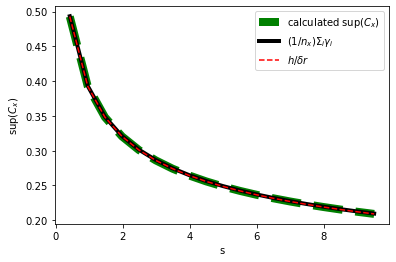

In [27]:
h = 1
dr = 1.
nx = 1000
I = np.zeros(nx).reshape(nx,1)
I[int(nx/2)] = 1

hs = np.arange(1,20,1.0)
ts = np.zeros_like(hs)
ss = np.zeros_like(hs)
ms = np.zeros_like(hs)
for i,h in enumerate(hs):
    alpha = np.exp(-dr / h)
    s = alpha/((1-alpha*alpha))
    ss[i] = s
    # square to get 2nd O difference
    lambda_i = diffFilter((nx,1),axis=(0,))**2
    gamma_i = 1/(1 + s * (lambda_i * lambda_i))
    ts[i] = (gamma_i.sum())/nx
    ms[i] = filt(I,gamma_i).max()
    
aa = np.sqrt(1 + 16*ss)
hh = np.sqrt((1+aa))/(np.sqrt(2)*aa)

plt.plot(ss,ms,'g--',lw=8,label='calculated $\sup(C_x)$')
plt.plot(ss,ts,'k',lw=4,label='$(1/n_x)\Sigma_i \gamma_i$')
plt.plot(ss,hh,'r--',label='$h/\delta r$')
plt.xlabel('s')
plt.ylabel('$\sup(C_x)$')
_=plt.legend()

Similarly for a first-order difference:

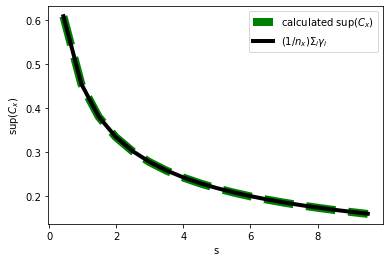

In [28]:
h = 1
dr = 1.
nx = 1000
I = np.zeros(nx).reshape(nx,1)
I[int(nx/2)] = 1

hs = np.arange(1,20,1.0)
ts = np.zeros_like(hs)
ss = np.zeros_like(hs)
ms = np.zeros_like(hs)
for i,h in enumerate(hs):
    alpha = np.exp(-dr / h)
    s = alpha/((1-alpha*alpha))
    ss[i] = s
    lambda_i = diffFilter((nx,1),axis=(0,))
    gamma_i = 1/(1 + s * (lambda_i * lambda_i))
    ts[i] = gamma_i.mean()
    ms[i] = filt(I,gamma_i).max()
    
plt.plot(ss,ms,'g--',lw=8,label='calculated $\sup(C_x)$')
plt.plot(ss,ts,'k',lw=4,label='$(1/n_x)\Sigma_i \gamma_i$')
plt.xlabel('s')
plt.ylabel('$\sup(C_x)$')
_=plt.legend()

So we have the correlation function defined as:


$$
\mathcal{C}_p = U^T \frac{1}{\bar{\gamma_i}} \left(   I_{n_x} + s \Gamma \right)^{-1} U
$$

